In [73]:
# Initialize the environment
import time, os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
# Prepare data 
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [75]:
# Check data
print train_images.shape
print len(train_labels)
print test_images.shape
print len(test_labels)

(60000, 28, 28)
60000
(10000, 28, 28)
10000


In [76]:
#  Preprocess data
#plt.figure()
#plt.imshow(train_images[0])
#plt.colorbar()
#plt.gca().grid(False)

train_images = train_images / 255.0
test_images = test_images / 255.0

In [77]:
# Create an simple model
def createModel(lr,reg):
    model = keras.Sequential([
            keras.layers.Flatten(input_shape=(28, 28)),
            keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(reg)),
            keras.layers.Dense(10, activation=tf.nn.softmax, kernel_regularizer=regularizers.l2(reg))
    ])
    model.compile(optimizer=tf.train.AdamOptimizer(lr), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [78]:
# Create tool for visualizeing quick scan
def visQuickScan(results):
    import math
    x_scatter = [math.log10(x[0]) for x in results]
    y_scatter = [math.log10(x[1]) for x in results]

    # plot training accuracy
    marker_size = 100
    colors = [results[x][0] for x in results]
    plt.subplot(2, 1, 1)
    plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
    plt.colorbar()
    plt.xlabel('log learning rate')
    plt.ylabel('log regularization')
    plt.title('training accuracy')

    # plot test accuracy
    colors = [results[x][1] for x in results] # default size of markers is 20
    plt.subplot(2, 1, 2)
    plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
    plt.colorbar()
    plt.xlabel('log learning rate')
    plt.ylabel('log regularization')
    plt.title(' test accuracy')
    plt.show()

In [79]:
# Create quick scan loop to find out the entry point
def quickScan(lr_range=[-3.0,-4.0],reg_range=[1,0],epoch=5,sample=10):
    # init
    results = {}
    learning_rates = lr_range
    regularization_strengths = reg_range
    best_val = -1
    best_lr, best_reg = 0, 0
    
    # Timing
    tic = time.time()
    for i in range(sample):
        lr = 10**np.random.uniform(learning_rates[0],learning_rates[1])
        reg = 10**np.random.uniform(regularization_strengths[0],regularization_strengths[1])
        print 'No.', str(i)
        print 'lr:', str(lr)
        print 'reg:', str(reg)
        
        # model
        model = createModel(lr,reg)
        #model.summary()
        
        # training
        model.fit(train_images, train_labels, epochs=epoch,
                  validation_data = (test_images,test_labels))
        
        # evaluate result
        train_loss, train_acc = model.evaluate(train_images, train_labels)
        test_loss, test_acc = model.evaluate(test_images, test_labels)
        print('Train accuracy:', train_acc)
        print('Test accuracy:', test_acc)
        
        # record
        results[(lr,reg)] = (train_acc,test_acc)
        if best_val < test_acc:
            print 'Found Better model!!!'
            best_val = test_acc
            best_lr = lr
            best_reg = reg
            model.save_weights('./weight/myBestweight')
    
    toc = time.time()
    print 'Total Training: computed in %fs' % (toc - tic)
    print 'Best Validation Record %.5f' % (best_val)
    print 'Best Validation learning rate %.10f' % (best_lr)
    print 'Best Validation regularization %.10f' % (best_reg)
    
    # Visaulize the distribution
    visQuickScan(results)
    
    return best_lr, best_reg
  

No. 0
lr: 0.000289907064899
reg: 6.17749178277e-05
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 126us/step - loss: 0.5809 - acc: 0.8082 - val_loss: 0.4987 - val_acc: 0.8351
Epoch 2/5
60000/60000 [==============================] - 6s 101us/step - loss: 0.4317 - acc: 0.8565 - val_loss: 0.4562 - val_acc: 0.8403
Epoch 3/5
60000/60000 [==============================] - 7s 110us/step - loss: 0.3978 - acc: 0.8674 - val_loss: 0.4201 - val_acc: 0.8585
Epoch 4/5
60000/60000 [==============================] - 7s 118us/step - loss: 0.3720 - acc: 0.8746 - val_loss: 0.4079 - val_acc: 0.8625
Epoch 5/5
10000/10000 [==============================] - 0s 49us/step
('Train accuracy:', 0.8882)
('Test accuracy:', 0.8693)
Found Better model!!!
No. 1
lr: 0.000270673178217
reg: 6.43379616929e-05
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 126us/step - loss: 0.5867 - acc: 0.8090 - v

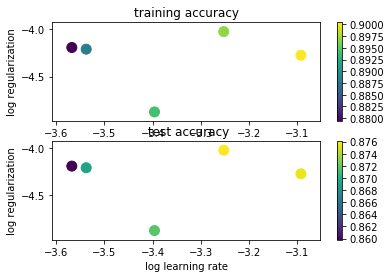

In [80]:
# Create the quick scan loop with the random learning rate & L2
best_lr, best_reg = quickScan(lr_range=[-3.0,-4.0],reg_range=[-4.0,-5.0],epoch=5,sample=5)

In [81]:
# Use best model to predict label

# load weight
model = createModel(best_lr, best_reg)
model.load_weights('./weight/myBestweight')

train_loss, train_acc = model.evaluate(train_images, train_labels)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

# predict
predictions = model.predict(test_images)
print predictions[0]
print np.argmax(predictions[0])
print test_labels[0]

10000/10000 [==============================] - 0s 49us/step
('Train accuracy:', 0.8968666666666667)
('Test accuracy:', 0.8761)
[7.7288350e-06 6.1271828e-07 1.3495276e-05 8.6794835e-06 1.0988902e-05
 3.6688570e-02 3.1061212e-05 4.5513283e-02 5.0864602e-04 9.1721690e-01]
9
9


In [ ]:
# Use the best model to train longer (marathon)
# Load weight, lr, reg
# Add checkpoint & tensorboard metrics